In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split


from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


In [2]:
# !pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.4/487.4 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 8.2 MB/s eta 0:00:00


In [3]:
from datasets import load_dataset

ds = load_dataset("shahxeebhassan/human_vs_ai_sentences")
ds

README.md:   0%|          | 0.00/1.37k [00:00<?, ?B/s]

complete_dataset.csv:   0%|          | 0.00/12.7M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/105000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 105000
    })
})

In [4]:
complete_data = ds['train'].to_pandas()
col_names = ['text','generated']
complete_data.columns = col_names

In [5]:
complete_data

,text,generated
0,Another reason why all students should have to...,0
1,Also the Electoral College consists of 538 ele...,0
2,Many countries have made changes in there town...,0
3,I believe the process of choosing a president ...,0
4,A thick cloud of carbon dioxide and heats to h...,0
...,...,...
104995,"In addition, without tree cover sunlight would...",1
104996,"Limited car usage also contributes to quieter,...",1
104997,I am confident that this experience will help ...,1
104998,There is an undeniable power in the way music ...,1


Here we have two columns -
1. Text - which show our input value
2. generated - This shows whether the text is generated by AI or not. 1 means generated by AI and 0 means generated by human.

In [6]:
#Let us check information about dataset

def data_info(data_frame):

  #Getting total shape and size of the dataset
  print("Shape of the dataset : ", data_frame.shape)
  print("-"*50)
  #getting information about dataset
  print(data_frame.info())
  print("-"*50)
  #Getting the count of null values in the dataset
  print("Total null values in the dataset are: \n",data_frame.isnull().sum())
  print("-"*50)
  #Getting count of duplicated rows
  print("Total duplicated rows in the dataset are: ",data_frame.duplicated().sum())
  print("-"*50)
  #Getting count of each variable of target variable
  print(data_frame["generated"].value_counts())

# data_info(data)
data_info(complete_data)

Shape of the dataset :  (105000, 2)
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105000 entries, 0 to 104999
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   text       105000 non-null  object
 1   generated  105000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.6+ MB
None
--------------------------------------------------
Total null values in the dataset are: 
 text         0
generated    0
dtype: int64
--------------------------------------------------
Total duplicated rows in the dataset are:  4614
--------------------------------------------------
generated
0    52500
1    52500
Name: count, dtype: int64


Since there are few duplicates present in this dataset, so best idea is to remove them.

In [7]:
#Removng duplicates and resetting index
# data = data.drop_duplicates().reset_index(drop=True)
# data_info(data)

complete_data = complete_data.drop_duplicates().reset_index(drop=True)
data_info(complete_data)

Shape of the dataset :  (100386, 2)
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100386 entries, 0 to 100385
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   text       100386 non-null  object
 1   generated  100386 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.5+ MB
None
--------------------------------------------------
Total null values in the dataset are: 
 text         0
generated    0
dtype: int64
--------------------------------------------------
Total duplicated rows in the dataset are:  0
--------------------------------------------------
generated
0    50986
1    49400
Name: count, dtype: int64


### Cleaning data

In [8]:
# Download necessary resources
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(column):
    column = column.lower()  # Convert to lowercase
    cloumn = re.sub(r'[^a-zA-Z0-9\s]', '', column)  # Remove special characters
    tokens = word_tokenize(column)  # Tokenization
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]  # Lemmatization & Stopword removal
    return " ".join(tokens)  # Convert back to string


# data['text'] = data['text'].apply(preprocess_text)

complete_data['text'] = complete_data['text'].apply(preprocess_text)


complete_data

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


,text,generated
0,another reason student participate least one e...,0
1,also electoral college consists 538 elector .,0
2,"many country made change town , city , village...",0
3,believe process choosing president changed ele...,0
4,thick cloud carbon dioxide heat high human bod...,0
...,...,...
100381,"addition , without tree cover sunlight would d...",1
100382,"limited car usage also contributes quieter , s...",1
100383,confident experience help gain invaluable know...,1
100384,undeniable power way music stir emotion transp...,1


In [9]:
# Feature Extraction
count_vectorizer = CountVectorizer(binary=True)
tfidf_vectorizer = TfidfVectorizer()


data = complete_data.copy()

#One-Hot Encoding (Bag of Words)
X_onehot = count_vectorizer.fit_transform(data["text"])

#TF-IDF
X_tfidf = tfidf_vectorizer.fit_transform(data["text"])

In [10]:
#getting the value in y variable
y = data["generated"]  # AI-generated (1) vs Human (0)

In [11]:
# Splitting data into train, validation, and test sets
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)
y_train_copy = y_train.copy()
X_train_tfidf, X_val_tfidf, y_train, y_val = train_test_split(X_train_tfidf, y_train, test_size=0.1, random_state=42)

X_train_onehot, X_test_onehot, _, _ = train_test_split(X_onehot, y, test_size=0.2, random_state=42)
X_train_onehot, X_val_onehot, _, _ = train_test_split(X_train_onehot, y_train_copy, test_size=0.1, random_state=42)

In [12]:
def classifiers(ml_algo, approach, x_train, x_test, y_train, y_test, vectorizer=None,top_n=None):


  """
  This function takes on 7 input values and pass on the output which shows the model performance, classification report and best features that helps it in classifiying the
  text as AI based and Human-generated.

  Input ->

      1. ml_algo -> Machine learning algorithm we are using
      2. approach -> The name of the approach you want currently we have two option ('TFIDF','Onehot')
      3. x_train -> the training data with input
      4. x_test -> test data with input values
      5. y_train -> output variables of training data
      6. y_test -> output variable of testing data
      7. vectorizer -> The kind of vectorizer we are using TFIDF or one-hot
  """
  print(f"This result belongs to {approach} approach.")

  algo = ml_algo
  algo.fit(x_train, y_train)
  predicted_val = algo.predict(x_test)

  print("Accuracy:", accuracy_score(y_test, predicted_val))
  print(classification_report(y_test, predicted_val))

  if hasattr(algo, 'coef_') and vectorizer is not None:
  # Feature importance analysis (if supported)
    print("\n--- Feature Importance Analysis ---")
    feature_names = vectorizer.get_feature_names_out()
    coefficients = algo.coef_[0]
    top_ai_words = sorted(zip(coefficients, feature_names), reverse=True)[:10]
    top_human_words = sorted(zip(coefficients, feature_names))[:10]

    print("\nWords most indicative of AI-generated text:")
    for weight, word in top_ai_words:
        print(f"{word}: {weight:.4f}")

    print("\nWords most indicative of human-generated text:")
    for weight, word in top_human_words:
        print(f"{word}: {weight:.4f}")

    print("\n")
  else:
    print("\n--- Feature Importance Analysis ---")
    feature_names = vectorizer.get_feature_names_out()
    importances = algo.feature_importances_

    importances_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    }).sort_values(by='importance', ascending=False)

    print(f"\nTop {top_n} important features:")
    print(importances_df.head(top_n).to_string(index=False))
    print("\n")



In [13]:
print("FOLLOWING RESULTS BELONG TO LOGISTIC REGRESSION\n")
classifiers(LogisticRegression(),'TFIDF',X_train_tfidf,X_test_tfidf,y_train,y_test,tfidf_vectorizer)
classifiers(LogisticRegression(),'OneHot',X_train_onehot,X_test_onehot,y_train,y_test,count_vectorizer)

FOLLOWING RESULTS BELONG TO LOGISTIC REGRESSION

This result belongs to TFIDF approach.
Accuracy: 0.8639306703854965
              precision    recall  f1-score   support

           0       0.86      0.87      0.87     10053
           1       0.87      0.86      0.86     10025

    accuracy                           0.86     20078
   macro avg       0.86      0.86      0.86     20078
weighted avg       0.86      0.86      0.86     20078


--- Feature Importance Analysis ---

Words most indicative of AI-generated text:
additionally: 7.5619
climate: 5.8484
ensure: 5.6639
potential: 5.3818
significant: 5.3064
firstly: 4.9724
essential: 4.9167
gun: 4.5999
super: 4.5467
provide: 4.3605

Words most indicative of human-generated text:
venus: -6.4799
dont: -5.6312
smog: -4.8315
project: -4.7487
student: -4.7452
voting: -4.7294
nasa: -4.6162
thats: -4.3919
car: -4.2906
paragraph: -4.2451


This result belongs to OneHot approach.
Accuracy: 0.8675166849287778
              precision    recall  

In [14]:
print("FOLLOWING RESULTS BELONG TO DECISION TREE CLASSIFIER\n")
classifiers(DecisionTreeClassifier(),'OneHot',X_train_onehot,X_test_onehot,y_train,y_test,count_vectorizer,10)
classifiers(DecisionTreeClassifier(),'TFIDF',X_train_tfidf,X_test_tfidf,y_train,y_test,tfidf_vectorizer,10)


FOLLOWING RESULTS BELONG TO DECISION TREE CLASSIFIER

This result belongs to OneHot approach.
Accuracy: 0.7827970913437593
              precision    recall  f1-score   support

           0       0.78      0.78      0.78     10053
           1       0.78      0.78      0.78     10025

    accuracy                           0.78     20078
   macro avg       0.78      0.78      0.78     20078
weighted avg       0.78      0.78      0.78     20078


--- Feature Importance Analysis ---

Top 10 important features:
     feature  importance
       would    0.023497
     driving    0.011280
       venus    0.011196
additionally    0.010940
   important    0.010425
  individual    0.008805
         get    0.008509
     provide    0.007806
        lead    0.007192
       could    0.007182


This result belongs to TFIDF approach.
Accuracy: 0.7780157386193844
              precision    recall  f1-score   support

           0       0.78      0.78      0.78     10053
           1       0.78      0.

In [15]:
print("FOLLOWING RESULTS BELONG TO RANDOM FOREST CLASSIFIER\n")

classifiers(RandomForestClassifier(),'TFIDF',X_train_tfidf,X_test_tfidf,y_train,y_test,tfidf_vectorizer,10 )
classifiers(RandomForestClassifier(),'OneHot',X_train_onehot,X_test_onehot,y_train,y_test,count_vectorizer,10 )




FOLLOWING RESULTS BELONG TO RANDOM FOREST CLASSIFIER

This result belongs to TFIDF approach.
Accuracy: 0.8632831955374041
              precision    recall  f1-score   support

           0       0.85      0.88      0.87     10053
           1       0.88      0.84      0.86     10025

    accuracy                           0.86     20078
   macro avg       0.86      0.86      0.86     20078
weighted avg       0.86      0.86      0.86     20078


--- Feature Importance Analysis ---

Top 10 important features:
     feature  importance
       would    0.011681
     student    0.011122
         car    0.007744
        like    0.007156
   important    0.006424
      people    0.005952
       venus    0.005643
additionally    0.005440
       phone    0.005280
         get    0.005259


This result belongs to OneHot approach.
Accuracy: 0.8607929076601255
              precision    recall  f1-score   support

           0       0.85      0.88      0.86     10053
           1       0.87      0.

## Compariso of Logistic Regression, Decision Tree and Random Forest for both approaches (One-hot and TFidf)

### 1. Logistic Regression (TF-IDF)
- **Accuracy of the model is:** 86.39%
- The model shows balanced precision and recall for both classes.
- words like "additionally", "climate", "potential" are more effective in identifing the text as AI-generated where as words like "venus", "dont", "smog* are effective in classifying text as HUman Generated

### 2. Logistic Regression (One-Hot Encoding)
- **Accuracy of the model is:** 86.75%
- Slight improvement in accuracy compared to TF-IDF.
- words like "eighth", "marijuana", "sustainable" are more effective in identifing the text as AI-generated where as words like "everybody", "alot", "collage" are effective in classifying text as HUman Generated.

### 3. Decision Tree (TF-IDF)
- **Accuracy of the model is:** 77.92%
- Lower performance; decision trees tend to overfit on sparse representations.
- **Top important words picked by DT are:** "wouldd, "student", "important".

### 4. Decision Tree (One-Hot Encoding)
- **Accuracy of the model is:** 78.56%
- Slightly better than TF-IDF but still lower than logistic regression and random forest.
- **Top important words picked by DT are:**  "would", "driving", "important".

### 5. Random Forest (TF-IDF)
- **Accuracy of the model is:** 86.09%
- Performed almost at par with logistic regression.
- **Important features as per the model are:** "would", "student", "car", "like".

### 6. Random Forest (One-Hot Encoding)
- **Accuracy of the model is:** 85.91%
- Slightly lower accuracy compared to TF-IDF.
- **Important features as per the model are:** "would", "important", "car", "venus".


## Overall Conclusion:
- **Best performer overall:** Logistic Regression (One-Hot) with 86.75% accuracy.
- **Best ensemble model:** Random Forest (TF-IDF).
- **Recommendation:** Use Logistic Regression with One-Hot encoding for interpretability and simplicity, or Random Forest with TF-IDF for robustness.


## Step - 4 Deep Learning-Based Classification

#### Step - 4.1

Initialize and configure your deep learning model correctly.

In [20]:
# Tokenization and Padding
tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")
tokenizer.fit_on_texts(complete_data['text'])  # Directly using the already cleaned 'text' column
sequences = tokenizer.texts_to_sequences(complete_data['text'])
padded_sequences = pad_sequences(sequences, maxlen=100, padding='post', truncating='post')

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, complete_data['generated'], test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

#### Task 4.2

Properly integrate a validation set to guide model
development and tuning.


Training with embedding dimension: 64
Epoch 1/5
2259/2259 ━━━━━━━━━━━━━━━━━━━━ 57s 21ms/step - accuracy: 0.7999 - loss: 0.4159 - val_accuracy: 0.8661 - val_loss: 0.3027 - learning_rate: 0.0010
Epoch 2/5
2259/2259 ━━━━━━━━━━━━━━━━━━━━ 78s 21ms/step - accuracy: 0.8871 - loss: 0.2735 - val_accuracy: 0.8744 - val_loss: 0.3004 - learning_rate: 0.0010
Epoch 3/5
2259/2259 ━━━━━━━━━━━━━━━━━━━━ 96s 28ms/step - accuracy: 0.9027 - loss: 0.2406 - val_accuracy: 0.8715 - val_loss: 0.3034 - learning_rate: 0.0010
Epoch 4/5
2259/2259 ━━━━━━━━━━━━━━━━━━━━ 67s 21ms/step - accuracy: 0.9096 - loss: 0.2180 - val_accuracy: 0.8741 - val_loss: 0.3229 - learning_rate: 0.0010
Epoch 5/5
2259/2259 ━━━━━━━━━━━━━━━━━━━━ 45s 20ms/step - accuracy: 0.9298 - loss: 0.1743 - val_accuracy: 0.8727 - val_loss: 0.3725 - learning_rate: 2.0000e-04
628/628 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step
Test Accuracy: 0.879370455224624
              precision    recall  f1-score   support

           0       0.87      0.89      0.88     10053

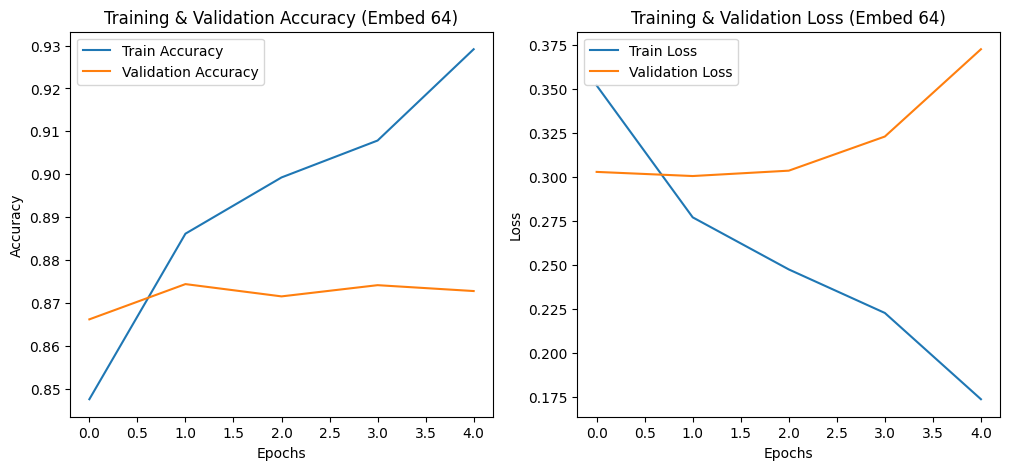


Training with embedding dimension: 128
Epoch 1/5
2259/2259 ━━━━━━━━━━━━━━━━━━━━ 52s 21ms/step - accuracy: 0.8044 - loss: 0.4126 - val_accuracy: 0.8735 - val_loss: 0.2983 - learning_rate: 0.0010
Epoch 2/5
2259/2259 ━━━━━━━━━━━━━━━━━━━━ 82s 21ms/step - accuracy: 0.8920 - loss: 0.2661 - val_accuracy: 0.8759 - val_loss: 0.2955 - learning_rate: 0.0010
Epoch 3/5
2259/2259 ━━━━━━━━━━━━━━━━━━━━ 81s 20ms/step - accuracy: 0.9068 - loss: 0.2263 - val_accuracy: 0.8750 - val_loss: 0.3019 - learning_rate: 0.0010
Epoch 4/5
2259/2259 ━━━━━━━━━━━━━━━━━━━━ 82s 20ms/step - accuracy: 0.9175 - loss: 0.2002 - val_accuracy: 0.8755 - val_loss: 0.3344 - learning_rate: 0.0010
Epoch 5/5
2259/2259 ━━━━━━━━━━━━━━━━━━━━ 81s 20ms/step - accuracy: 0.9381 - loss: 0.1535 - val_accuracy: 0.8782 - val_loss: 0.3830 - learning_rate: 2.0000e-04
628/628 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step
Test Accuracy: 0.8756848291662516
              precision    recall  f1-score   support

           0       0.86      0.89      0.88     100

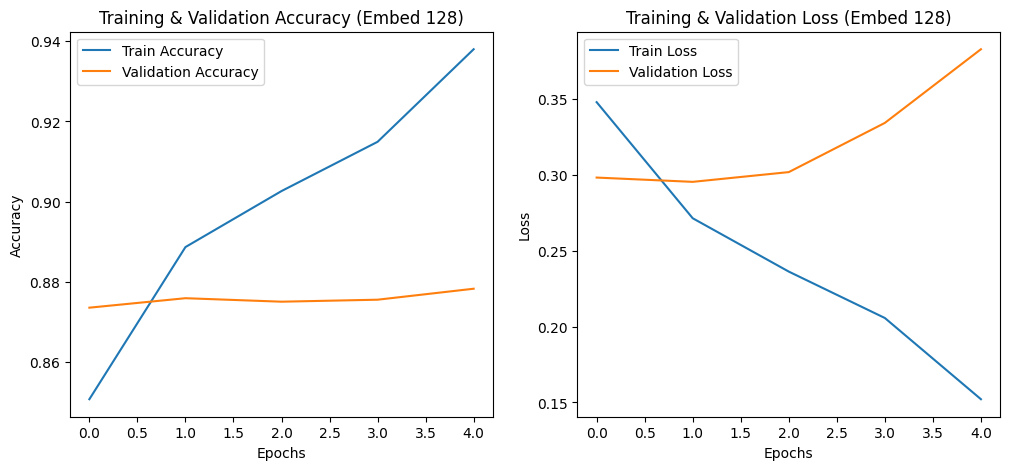


Training with embedding dimension: 256
Epoch 1/5
2259/2259 ━━━━━━━━━━━━━━━━━━━━ 56s 23ms/step - accuracy: 0.8072 - loss: 0.4077 - val_accuracy: 0.8729 - val_loss: 0.2992 - learning_rate: 0.0010
Epoch 2/5
2259/2259 ━━━━━━━━━━━━━━━━━━━━ 80s 22ms/step - accuracy: 0.8964 - loss: 0.2579 - val_accuracy: 0.8793 - val_loss: 0.2932 - learning_rate: 0.0010
Epoch 3/5
2259/2259 ━━━━━━━━━━━━━━━━━━━━ 80s 21ms/step - accuracy: 0.9118 - loss: 0.2180 - val_accuracy: 0.8774 - val_loss: 0.3107 - learning_rate: 0.0010
Epoch 4/5
2259/2259 ━━━━━━━━━━━━━━━━━━━━ 83s 22ms/step - accuracy: 0.9255 - loss: 0.1845 - val_accuracy: 0.8785 - val_loss: 0.3235 - learning_rate: 0.0010
Epoch 5/5
2259/2259 ━━━━━━━━━━━━━━━━━━━━ 48s 21ms/step - accuracy: 0.9437 - loss: 0.1409 - val_accuracy: 0.8808 - val_loss: 0.4049 - learning_rate: 2.0000e-04
628/628 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step
Test Accuracy: 0.8785735631038948
              precision    recall  f1-score   support

           0       0.88      0.88      0.88     100

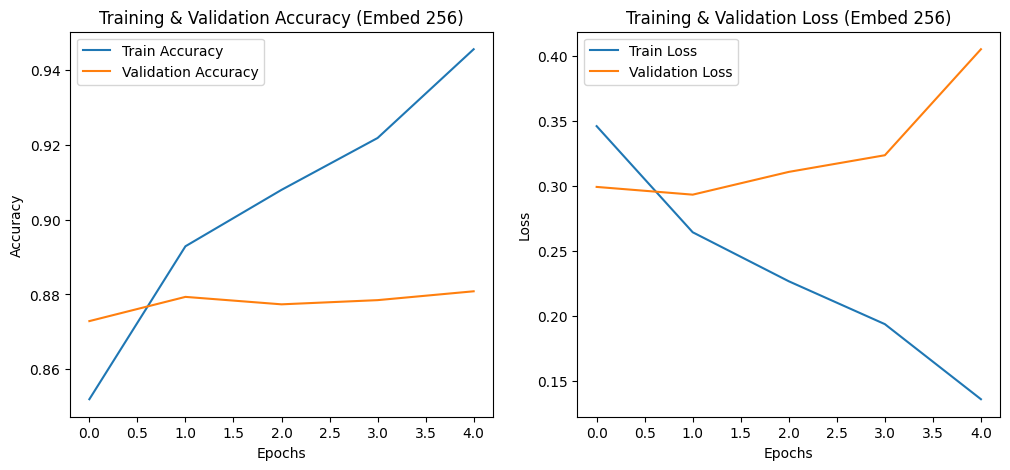

In [23]:
for embedding_dim in [64, 128, 256]:

  #running a loop over embedding values
    print(f"\nTraining with embedding dimension: {embedding_dim}")

    #Configuring the model required with suitable output dim
    model = Sequential([
        Embedding(input_dim=5000, output_dim=embedding_dim, input_length=100),
        Bidirectional(LSTM(64, return_sequences=True)),
        Dropout(0.5),
        Bidirectional(LSTM(32)),
        Dense(32, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001)

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=5,
        batch_size=32,
        callbacks=[early_stopping, reduce_lr]
    )


    #Prediction of the model
    y_pred = (model.predict(X_test) > 0.5).astype("int32")
    print("Test Accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))

    # Plotting training vs validation accuracy and loss
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'Training & Validation Accuracy (Embed {embedding_dim})')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Training & Validation Loss (Embed {embedding_dim})')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

### Model Performance Summary
The model was trained with embedding dimensions of 64, 128, and 256. The training and validation accuracy and loss graphs for each configuration are included in the results.

### Observations:
- **Embedding Dimension 64:**
  - Test Accuracy: 87.9%
  - Strong convergence with good training accuracy.

- **Embedding Dimension 128:**
  - Test Accuracy: 87.56%
  - Similar trend as with 64, but training accuracy improved slightly.
  - Validation accuracy remained steady but there were overfitting

- **Embedding Dimension 256:**
  - Test Accuracy: 87.87%
  - Highest training accuracy and further reduced training loss.
  - Slight improvement in performance and strong sign of overfitting.
